In [3]:
import random
import math
import numpy as np
import pandas as pd
import os

from IPython.display import display
from sklearn import linear_model
#线性模型
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
#决策树
from sklearn.neighbors import NearestNeighbors
#临近算法

In [4]:
def get_data():
    path = os.getcwd()
    print('path',path)
    name = os.listdir(path)
    #获取当前目录的所有文件，返回一个数组
    name0 = []
    l = []
    for i in name:
        if i in ['ant','ivy','synapse']:
            new_path = path+'\\'+i
            print('new_path',new_path)
            output = []
            for j in os.listdir(new_path):
                data = pd.read_csv(new_path+'\\'+j,engine='python')
                output.append(data)
            output = pd.concat(output,axis=0)
            #实现数据的联合
            name0.append(i)
            l.append(output)
            print(name0,l)
    return name0,l

#使用文件遍历的方法，实现同时对三种不同的数据集进行遍历，实现横向比较
#从指定的文件夹下读取数据，通过配置不同的数据，可以比较各种算法在不同的数据集上的表现

## 数据集分析函数
+ 输入数据集以及Type，
+ Type == -1时，返回数据集中的（1）缺陷模块数据集（2）缺陷模块的特征数据集（3）缺陷模块的bug数据集
+ Type == 0时，返回数据集中的（1）模块特征数据集（2）模块bug数据集
+ Type == 1时，返回数据集中的（1）正常模块数据集（2）正常模块的特征数据集

In [5]:
def seperateData(modules, Type):
    if Type==-1:
        rare_modules = modules[modules.bug!=0]
        rare_char = rare_modules.iloc[:, :-1]
        rare_bug = rare_modules.iloc[:, -1]
        return rare_modules, rare_char, rare_bug
    elif Type==1:
        normal_modules = modules[modules.bug==0]
        normal_char = normal_modules.iloc[:, :-1]
        return normal_modules, normal_char
    else:
        char = modules.iloc[:, :-1]
        bug = modules.iloc[:, -1]
        return char, bug

## SMOTE过采样函数

smote（Synthetic Minority Oversampling Technique）

合成少数类过采样技术．它是基于随机过采样算法的一种改进方案，由于随机过采样采取简单复制样本的策略来增加少数类样本，这样容易产生模型过拟合的问题，即使得模型学习到的信息过于特别(Specific)而不够泛化(General)，SMOTE算法的基本思想是对少数类样本进行分析并根据少数类样本人工合成新样本添加到数据集中

-- 由于数据种类过多。导致单个种类的数据在总体数据中所占的比例较小，所以我们决定使用smote算法，来进行数据的采集效果会更加的好 --


+ Input:训练模块数据集，k邻近的值，从k邻近中任取n个值
+ Output：经过SMOTE过采样后的新数据集，dataframe格式，21维，包含20维的特征值和1维的bug数量

In [6]:
def smote(modules_input, ratio):
    modules, char, bug = seperateData(modules_input, -1)
    normal_modules, normal_char = seperateData(modules_input, 1)
    
    n = round((ratio*normal_modules.shape[0]-modules.shape[0])/modules.shape[0])
    k = 5
    
    if n<=0:
        return modules_input
    
    # 训练模型，取邻近的k个点（可修改邻近点数）
    neigh = NearestNeighbors(n_neighbors=k, algorithm='ball_tree', n_jobs=-1)
    neigh.fit(char)
    index = neigh.kneighbors(n_neighbors=k,return_distance=False)
    # result结果为narray类型的索引矩阵
    a, b = index.shape

    axis0, axis1 = np.ogrid[:a, :b]
    sort_axis = np.zeros(b,dtype=int)
    for i in range(a):
        temp = np.arange(b)
        # 从k个邻近中随机抽取n个邻近
        np.random.shuffle(temp)
        sort_axis = np.vstack((sort_axis,temp))
    # index_rand就是最终过采样得到矩阵的 下标
    sort_axis = sort_axis[1:]
    index_rand = index[axis0, sort_axis]

    flag = 0
    new_list = []
    for i in range(a):
        for j in range(n):
            p = index_rand[i][np.random.randint(0,k)]

#             p = index_rand[i][j]
            # 计算新的模块的各项特征
            new = char.iloc[i]+(char.iloc[p]-char.iloc[i])*np.random.rand()
            #计算原两个模块与新模块之间的欧氏距离
            d1 = np.linalg.norm(new-char.iloc[i])
            d2 = np.linalg.norm(new-char.iloc[p])
            if d1 == 0 and d2 == 0:
                break
            # 计算新模块的缺陷个数
            bug_new = (d2*modules.iloc[i].loc['bug']+d1*modules.iloc[p].loc['bug'])/(d1+d2)
            bug_new = float(round(bug_new))
            # 将新模块的各项特征和缺陷个数合并
            new['bug'] = bug_new
            new_list.append(new)
            flag += 1
    # 将缺陷模块数据集和正常模块数据集合并

    modules = pd.concat([modules,pd.concat(new_list,axis=1).T],axis=0)
    # modules_new的样式分为三部分，最上面时旧的缺陷数据集，中间时新合成的缺陷数据集，下面时正常数据集
    modules_new = pd.concat([modules, normal_modules], axis=0)
#     modules_new = modules_new.dropna(axis=0)
    
    return modules_new

#也就是说loc是根据index来索引，比如下边的df定义了一个index，那么loc就根据这个index来索引对应的行。
#iloc并不是根据index来索引，而是根据行号来索引，行号从0开始，逐次加1。也就是说他们都是索引数据的方法

## 决策树函数
+ Input: 训练数据集的自变量，训练数据集的因变量，测试数据集的自变量
+ Output: 测试数据集因变量，即预测出的bug数量，narray格式

In [7]:
def decisiontree(trainChar,trainBug, testChar):
    dtr = DecisionTreeRegressor()
    dtr.fit(trainChar,trainBug)
    return dtr.predict(testChar).astype(int)

In [8]:
# def decisiontree(train_data_X, train_data_y, test_data_X):
#     lr = linear_model.LinearRegression().fit(train_data_X, train_data_y)
#     return lr.predict(test_data_X).astype(int)

In [9]:
# def decisiontree(train_data_X, train_data_y, test_data_X):
#     bayes = BayesianRidge().fit(train_data_X, train_data_y)
#     return bayes.predict(test_data_X).astype(int)

## FPA计算函数

Function Point Analysis.功能点分析方法是最重要也是最有效的软件测量规模方法,

#### 可以度量软件的规模是否合理

+ Input: 测试数据集的 实际 bug， 测试数据集的 预测 bug
+ Output: FPA值

In [10]:
def FPA(testBug, testPre):
    K = len(testBug)
    N = np.sum(testBug)
    sort_axis = np.argsort(testPre)
    testBug=np.array(testBug)
    testBug = testBug[sort_axis]
    P = sum(np.sum(testBug[m:])/N for m in range(K+1))/K
    return P

## 十折交叉验证法函数

-- 是常用的测试方法。将数据集分成十份，轮流将其中9份作为训练数据，1份作为测试数据，进行试验。
    每次试验都会得出相应的正确率（或差错率）。10次的结果的正确率（或差错率）的平均值作为对算法精度的估计，一般还需要进行多次10折交叉验证（例如10次10折交叉验证），再求其均值，作为对算法准确性的估计。--
    
    
    
## bagging算法
  bagging（bootstrap aggregating）是一种用来提高学习算法准确度的方法，这种方法通过构造一个预测函数系列，然后以一定的方式将它们组合成一个预测函数。
  
+ Input: 总数据集
+ Output: FPA

In [11]:
def Smote_Bagging(dataset,n):
    rare_modules, rare_char, rare_bug = seperateData(dataset, -1)
    normal_modules, normal_char = seperateData(dataset, 1)
    rare_test_len = math.ceil(rare_modules.shape[0]/10)
    normal_test_len = math.ceil(normal_char.shape[0]/10)
    temp = np.array([])
    
    dataset_temp = []
    # 十折交叉验证，循环十次
    for i in range(10):
        rareX0 = i*rare_test_len
        rareX1 = (i+1)*rare_test_len
        normalX0 = i*normal_test_len
        normalX1= (i+1)*normal_test_len
        
        if rareX1 >=rare_modules.shape[0]:
            rareX1 = rare_modules.shape[0]
        if normalX1 >= normal_modules.shape[0]:
            normalX1 = normal_modules.shape[0]
         # 测试集， 取1/10的数据集
        testMod = pd.concat([rare_modules.iloc[rareX0:rareX1], normal_modules.iloc[normalX0:normalX1]],axis=0)
        # 训练集，取剩下的数据集
        trainMod = pd.concat([rare_modules.drop(rare_modules.index[list(range(rareX0,rareX1))]),normal_modules.drop(normal_modules.index[list(range(normalX0,normalX1))])],axis=0)
        dataset_temp.append(testMod)
        # 用以储存测试集预测Bug数据集
        testPre_sum = np.zeros(len(testMod))

        flag = 0
        # 每一折进行20次过采样
        for j in range(n):
            # 对训练集进行过采样
            trainMod_new = smote(trainMod,1)
            trainMod_new = trainMod_new.dropna(axis=0)
            # 提取 特征值 和 bug值
            trainChar, trainBug = seperateData(trainMod_new, 0)
            testChar, testBug = seperateData(testMod, 0)

            testPre = decisiontree(trainChar, trainBug, testChar)
            flag += 1
            testPre_sum += testPre
        # 对预测结果求平均
        testPre_sum /= flag
        temp = np.hstack((temp, testPre_sum))
    dataset_new = pd.concat(dataset_temp,axis=0)
    dataset_new['bug_new'] = temp
    P = FPA(dataset_new['bug'],dataset_new['bug_new'])
    print('{:<20}:{:>8.4f}'.format('SMOTE & Bagging',P))
    return P

In [12]:
def Smote_NoBagging(dataset):
    rare_modules, rare_char, rare_bug = seperateData(dataset, -1)
    normal_modules, normal_char = seperateData(dataset, 1)
    rare_test_len = math.ceil(rare_modules.shape[0]/10)
    normal_test_len = math.ceil(normal_char.shape[0]/10)
    temp = np.array([])
    dataset_temp = []
    
    # 十折交叉验证，循环十次
    for i in range(10):
        rareX0 = i*rare_test_len
        rareX1 = (i+1)*rare_test_len
        normalX0 = i*normal_test_len
        normalX1= (i+1)*normal_test_len
        
        if rareX1 >=rare_modules.shape[0]:
            rareX1 = rare_modules.shape[0]
        if normalX1 >= normal_modules.shape[0]:
            normalX1 = normal_modules.shape[0]
        # 测试集， 取1/10的数据集
        testMod = pd.concat([rare_modules.iloc[rareX0:rareX1], normal_modules.iloc[normalX0:normalX1]],axis=0)
        # 训练集，取剩下的数据集
        trainMod = pd.concat([rare_modules.drop(rare_modules.index[list(range(rareX0,rareX1))]),normal_modules.drop(normal_modules.index[list(range(normalX0,normalX1))])],axis=0)
        dataset_temp.append(testMod)
        
        # 用以储存测试集预测Bug数据集
        testPre_sum = np.zeros(len(testMod))

        # 对训练集进行过采样
        trainMod_new = smote(trainMod,1)
        #display(trainMod_new)
        trainMod_new = trainMod_new.dropna(axis=0)
        # 提取 特征值 和 bug值
        trainChar, trainBug = seperateData(trainMod_new, 0)
        testChar, testBug = seperateData(testMod, 0)

        testPre = decisiontree(trainChar, trainBug, testChar)

        temp = np.hstack((temp, testPre))
    dataset_new = pd.concat(dataset_temp,axis=0)
    dataset_new['bug_new'] = temp
    P = FPA(dataset_new['bug'],dataset_new['bug_new'])
    print('{:<20}:{:>8.4f}'.format('SMOTE & NoBagging',P))
    return P

In [13]:
def NoSmote_Bagging(dataset,n):
    rare_modules, rare_char, rare_bug = seperateData(dataset, -1)
    normal_modules, normal_char = seperateData(dataset, 1)
    rare_test_len = math.ceil(rare_modules.shape[0]/10)
    normal_test_len = math.ceil(normal_char.shape[0]/10)
    temp = np.array([])
    dataset_temp = []
    # 十折交叉验证，循环十次
    for i in range(10):
        rareX0 = i*rare_test_len
        rareX1 = (i+1)*rare_test_len
        normalX0 = i*normal_test_len
        normalX1= (i+1)*normal_test_len
        
        if rareX1 >=rare_modules.shape[0]:
            rareX1 = rare_modules.shape[0]
        if normalX1 >= normal_modules.shape[0]:
            normalX1 = normal_modules.shape[0]
        # 测试集， 取1/10的数据集
        testMod = pd.concat([rare_modules.iloc[rareX0:rareX1], normal_modules.iloc[normalX0:normalX1]],axis=0)
         # 训练集，取剩下的数据集
        trainMod = pd.concat([rare_modules.drop(rare_modules.index[list(range(rareX0,rareX1))]),normal_modules.drop(normal_modules.index[list(range(normalX0,normalX1))])],axis=0)
        dataset_temp.append(testMod)
        
        # 用以储存测试集预测Bug数据集
        testPre_sum = np.zeros(len(testMod))

        flag = 0
        for j in range(n):
            # 提取 特征值 和 bug值
            trainChar, trainBug = seperateData(trainMod, 0)
            testChar, testBug = seperateData(testMod, 0)

            testPre = decisiontree(trainChar, trainBug, testChar)

            flag += 1
            testPre_sum += testPre
        # 对预测结果求平均
        testPre_sum /= flag
        temp = np.hstack((temp, testPre_sum))
    dataset_new = pd.concat(dataset_temp,axis=0)
    dataset_new['bug_new'] = temp
    P = FPA(dataset_new['bug'],dataset_new['bug_new'])
    print('{:<20}:{:>8.4f}'.format('NoSMOTE & Bagging',P))
    return P

In [14]:
def NoSmote_NoBagging(dataset):
    rare_modules, rare_char, rare_bug = seperateData(dataset, -1)
    normal_modules, normal_char = seperateData(dataset, 1)
    rare_test_len = math.ceil(rare_modules.shape[0]/10)
    normal_test_len = math.ceil(normal_char.shape[0]/10)
    temp = np.array([])
    
    dataset_temp = []
    # 十折交叉验证，循环十次
    for i in range(10):
        rareX0 = i*rare_test_len
        rareX1 = (i+1)*rare_test_len
        normalX0 = i*normal_test_len
        normalX1= (i+1)*normal_test_len
        
        if rareX1 >=rare_modules.shape[0]:
            rareX1 = rare_modules.shape[0]
        if normalX1 >= normal_modules.shape[0]:
            normalX1 = normal_modules.shape[0]
        
        # 测试集， 取1/10的数据集
        testMod = pd.concat([rare_modules.iloc[rareX0:rareX1], normal_modules.iloc[normalX0:normalX1]],axis=0)
        # 训练集，取剩下的数据集
        trainMod = pd.concat([rare_modules.drop(rare_modules.index[list(range(rareX0,rareX1))]),normal_modules.drop(normal_modules.index[list(range(normalX0,normalX1))])],axis=0)
        dataset_temp.append(testMod)
        
        # 提取 特征值 和 bug值
        trainChar, trainBug = seperateData(trainMod, 0)
        testChar, testBug = seperateData(testMod, 0)

        testPre = decisiontree(trainChar, trainBug, testChar)
        temp = np.hstack((temp, testPre))
    dataset_new = pd.concat(dataset_temp,axis=0)
    dataset_new['bug_new'] = temp
    P = FPA(dataset_new['bug'],dataset_new['bug_new'])
    print('{:<20}:{:>8.4f}'.format('NoSMOTE & NoBagging',P))
    return P

In [27]:
line = list(range(1,10))
line[len(line):len(line)]=list(range(10,50,5))

In [28]:
final_output = []
for (i,j) in zip(*get_data()):
    l = []
    print(i)
    if j.shape[1] == 24:
        j = j.drop(j.columns[[0,1,2]], axis=1)
    else:
        j = j.drop(j.columns[[0,1,2,3]], axis=1)
    for k in line:
#         其中注释为可选的方法，通过比较不同方法的最终的学习效果找到最适合，用户软件缺陷预测的模型
#         temp = NoSmote_Bagging(j,k)
#         temp = Smote_NoBagging(j)
        temp = NoSmote_NoBagging(j)
#         temp = Smote_Bagging(j,k)
        l.append(temp)
    final_output.append(l)

path C:\Users\小马\TensorFlow\original
new_path C:\Users\小马\TensorFlow\original\ant
['ant'] [    name  version                                             name.1  wmc  \
0    ant      1.3            org.apache.tools.ant.taskdefs.ExecuteOn   11   
1    ant      1.3                 org.apache.tools.ant.DefaultLogger   14   
2    ant      1.3     org.apache.tools.ant.taskdefs.TaskOutputStream    3   
3    ant      1.3                  org.apache.tools.ant.taskdefs.Cvs   12   
4    ant      1.3             org.apache.tools.ant.taskdefs.Copyfile    6   
5    ant      1.3        org.apache.tools.ant.util.GlobPatternMapper    5   
6    ant      1.3                 org.apache.tools.ant.taskdefs.Move    4   
7    ant      1.3                org.apache.tools.tar.TarInputStream   16   
8    ant      1.3          org.apache.tools.ant.taskdefs.CompileTask    4   
9    ant      1.3              org.apache.tools.ant.types.PatternSet   17   
10   ant      1.3                org.apache.tools.ant.taskdefs

['ant', 'ivy', 'synapse'] [    name  version                                             name.1  wmc  \
0    ant      1.3            org.apache.tools.ant.taskdefs.ExecuteOn   11   
1    ant      1.3                 org.apache.tools.ant.DefaultLogger   14   
2    ant      1.3     org.apache.tools.ant.taskdefs.TaskOutputStream    3   
3    ant      1.3                  org.apache.tools.ant.taskdefs.Cvs   12   
4    ant      1.3             org.apache.tools.ant.taskdefs.Copyfile    6   
5    ant      1.3        org.apache.tools.ant.util.GlobPatternMapper    5   
6    ant      1.3                 org.apache.tools.ant.taskdefs.Move    4   
7    ant      1.3                org.apache.tools.tar.TarInputStream   16   
8    ant      1.3          org.apache.tools.ant.taskdefs.CompileTask    4   
9    ant      1.3              org.apache.tools.ant.types.PatternSet   17   
10   ant      1.3                org.apache.tools.ant.taskdefs.Patch    9   
11   ant      1.3                org.apache.tools

NoSMOTE & NoBagging :  0.6850
NoSMOTE & NoBagging :  0.6773
NoSMOTE & NoBagging :  0.6835
NoSMOTE & NoBagging :  0.6967
NoSMOTE & NoBagging :  0.6906
NoSMOTE & NoBagging :  0.6902
NoSMOTE & NoBagging :  0.6952
NoSMOTE & NoBagging :  0.6844
NoSMOTE & NoBagging :  0.6932
NoSMOTE & NoBagging :  0.6884
NoSMOTE & NoBagging :  0.6896
NoSMOTE & NoBagging :  0.6790
NoSMOTE & NoBagging :  0.7023
NoSMOTE & NoBagging :  0.6813
NoSMOTE & NoBagging :  0.6614
NoSMOTE & NoBagging :  0.6882
NoSMOTE & NoBagging :  0.6891
NoSMOTE & NoBagging :  0.6937
NoSMOTE & NoBagging :  0.6941
NoSMOTE & NoBagging :  0.6844
NoSMOTE & NoBagging :  0.6867
NoSMOTE & NoBagging :  0.6863
NoSMOTE & NoBagging :  0.6945
NoSMOTE & NoBagging :  0.6918
NoSMOTE & NoBagging :  0.6924
NoSMOTE & NoBagging :  0.6949
NoSMOTE & NoBagging :  0.6730
NoSMOTE & NoBagging :  0.6798
NoSMOTE & NoBagging :  0.6885
NoSMOTE & NoBagging :  0.6671
NoSMOTE & NoBagging :  0.6781
NoSMOTE & NoBagging :  0.6997
NoSMOTE & NoBagging :  0.6974
NoSMOTE & 

NoSMOTE & NoBagging :  0.6873
NoSMOTE & NoBagging :  0.6912
NoSMOTE & NoBagging :  0.6887
NoSMOTE & NoBagging :  0.6817
NoSMOTE & NoBagging :  0.6808
NoSMOTE & NoBagging :  0.6838
NoSMOTE & NoBagging :  0.6742
NoSMOTE & NoBagging :  0.6698
NoSMOTE & NoBagging :  0.6927
NoSMOTE & NoBagging :  0.6960
NoSMOTE & NoBagging :  0.6914
NoSMOTE & NoBagging :  0.6965
NoSMOTE & NoBagging :  0.6769
NoSMOTE & NoBagging :  0.7027
NoSMOTE & NoBagging :  0.6778
NoSMOTE & NoBagging :  0.6858
NoSMOTE & NoBagging :  0.6910
NoSMOTE & NoBagging :  0.6944
NoSMOTE & NoBagging :  0.6906
NoSMOTE & NoBagging :  0.6629
NoSMOTE & NoBagging :  0.6883
NoSMOTE & NoBagging :  0.6896
NoSMOTE & NoBagging :  0.6771
NoSMOTE & NoBagging :  0.6953
NoSMOTE & NoBagging :  0.6915
NoSMOTE & NoBagging :  0.6686
NoSMOTE & NoBagging :  0.7011
NoSMOTE & NoBagging :  0.7034
NoSMOTE & NoBagging :  0.6936
NoSMOTE & NoBagging :  0.6795
NoSMOTE & NoBagging :  0.6918
NoSMOTE & NoBagging :  0.6861
NoSMOTE & NoBagging :  0.6861
NoSMOTE & 

NoSMOTE & NoBagging :  0.6963
NoSMOTE & NoBagging :  0.6927
NoSMOTE & NoBagging :  0.7203
NoSMOTE & NoBagging :  0.7096
NoSMOTE & NoBagging :  0.6975
NoSMOTE & NoBagging :  0.6863
NoSMOTE & NoBagging :  0.7188
NoSMOTE & NoBagging :  0.6983
NoSMOTE & NoBagging :  0.7149
NoSMOTE & NoBagging :  0.7132
NoSMOTE & NoBagging :  0.7172
NoSMOTE & NoBagging :  0.7312
NoSMOTE & NoBagging :  0.7115
NoSMOTE & NoBagging :  0.7184
NoSMOTE & NoBagging :  0.7274
NoSMOTE & NoBagging :  0.7109
NoSMOTE & NoBagging :  0.7024
NoSMOTE & NoBagging :  0.7162
NoSMOTE & NoBagging :  0.7109
NoSMOTE & NoBagging :  0.7043
NoSMOTE & NoBagging :  0.7169
NoSMOTE & NoBagging :  0.6973
NoSMOTE & NoBagging :  0.6889
NoSMOTE & NoBagging :  0.7059
NoSMOTE & NoBagging :  0.7127
NoSMOTE & NoBagging :  0.7037
NoSMOTE & NoBagging :  0.7295
NoSMOTE & NoBagging :  0.7071
NoSMOTE & NoBagging :  0.7043
NoSMOTE & NoBagging :  0.7042
NoSMOTE & NoBagging :  0.7016
NoSMOTE & NoBagging :  0.6859
NoSMOTE & NoBagging :  0.7221
NoSMOTE & 

NoSMOTE & NoBagging :  0.6977
NoSMOTE & NoBagging :  0.7042
NoSMOTE & NoBagging :  0.6965
NoSMOTE & NoBagging :  0.6921
NoSMOTE & NoBagging :  0.7314
NoSMOTE & NoBagging :  0.7090
NoSMOTE & NoBagging :  0.7025
NoSMOTE & NoBagging :  0.7162
NoSMOTE & NoBagging :  0.7057
NoSMOTE & NoBagging :  0.7037
NoSMOTE & NoBagging :  0.7055
NoSMOTE & NoBagging :  0.7110
NoSMOTE & NoBagging :  0.7233
NoSMOTE & NoBagging :  0.7201
NoSMOTE & NoBagging :  0.6887
NoSMOTE & NoBagging :  0.7162
NoSMOTE & NoBagging :  0.7014
NoSMOTE & NoBagging :  0.7167
NoSMOTE & NoBagging :  0.7015
NoSMOTE & NoBagging :  0.6883
NoSMOTE & NoBagging :  0.7037
NoSMOTE & NoBagging :  0.6950
NoSMOTE & NoBagging :  0.7143
NoSMOTE & NoBagging :  0.7122
NoSMOTE & NoBagging :  0.7223
NoSMOTE & NoBagging :  0.7096
NoSMOTE & NoBagging :  0.6872
NoSMOTE & NoBagging :  0.7067
NoSMOTE & NoBagging :  0.6962
NoSMOTE & NoBagging :  0.7304
NoSMOTE & NoBagging :  0.6976
NoSMOTE & NoBagging :  0.6861
NoSMOTE & NoBagging :  0.7048
NoSMOTE & 

NoSMOTE & NoBagging :  0.6376
NoSMOTE & NoBagging :  0.6473
NoSMOTE & NoBagging :  0.6513
NoSMOTE & NoBagging :  0.6348
NoSMOTE & NoBagging :  0.6365
NoSMOTE & NoBagging :  0.6343
NoSMOTE & NoBagging :  0.6410
NoSMOTE & NoBagging :  0.6286
NoSMOTE & NoBagging :  0.6352
NoSMOTE & NoBagging :  0.6327
NoSMOTE & NoBagging :  0.6404
NoSMOTE & NoBagging :  0.6213
NoSMOTE & NoBagging :  0.6335
NoSMOTE & NoBagging :  0.6350
NoSMOTE & NoBagging :  0.6291
NoSMOTE & NoBagging :  0.6312
NoSMOTE & NoBagging :  0.6392
NoSMOTE & NoBagging :  0.6310
NoSMOTE & NoBagging :  0.6250
NoSMOTE & NoBagging :  0.6383
NoSMOTE & NoBagging :  0.6300
NoSMOTE & NoBagging :  0.6317
NoSMOTE & NoBagging :  0.6353
NoSMOTE & NoBagging :  0.6305
NoSMOTE & NoBagging :  0.6330
NoSMOTE & NoBagging :  0.6344
NoSMOTE & NoBagging :  0.6409
NoSMOTE & NoBagging :  0.6470
NoSMOTE & NoBagging :  0.6373
NoSMOTE & NoBagging :  0.6325
NoSMOTE & NoBagging :  0.6316
NoSMOTE & NoBagging :  0.6356
NoSMOTE & NoBagging :  0.6237
NoSMOTE & 

NoSMOTE & NoBagging :  0.6361
NoSMOTE & NoBagging :  0.6375
NoSMOTE & NoBagging :  0.6309
NoSMOTE & NoBagging :  0.6170
NoSMOTE & NoBagging :  0.6551
NoSMOTE & NoBagging :  0.6249
NoSMOTE & NoBagging :  0.6359
NoSMOTE & NoBagging :  0.6438
NoSMOTE & NoBagging :  0.6537
NoSMOTE & NoBagging :  0.6215
NoSMOTE & NoBagging :  0.6271
NoSMOTE & NoBagging :  0.6461
NoSMOTE & NoBagging :  0.6297
NoSMOTE & NoBagging :  0.6298
NoSMOTE & NoBagging :  0.6375
NoSMOTE & NoBagging :  0.6420
NoSMOTE & NoBagging :  0.6451
NoSMOTE & NoBagging :  0.6426
NoSMOTE & NoBagging :  0.6497
NoSMOTE & NoBagging :  0.6250
NoSMOTE & NoBagging :  0.6373
NoSMOTE & NoBagging :  0.6217
NoSMOTE & NoBagging :  0.6254
NoSMOTE & NoBagging :  0.6503
NoSMOTE & NoBagging :  0.6317
NoSMOTE & NoBagging :  0.6223
NoSMOTE & NoBagging :  0.6308
NoSMOTE & NoBagging :  0.6301
NoSMOTE & NoBagging :  0.6469
NoSMOTE & NoBagging :  0.6276
NoSMOTE & NoBagging :  0.6236
NoSMOTE & NoBagging :  0.6373
NoSMOTE & NoBagging :  0.6148
NoSMOTE & 

In [29]:
for i in final_output:
    print(i)
print(final_output)

[0.6849538506073439, 0.6772502236028097, 0.6834554334554311, 0.6966684109541306, 0.6905624770366426, 0.6902126917324503, 0.695158860052478, 0.6844379868695963, 0.6932392160355657, 0.6883644892763453, 0.6895873461223013, 0.678972243561908, 0.7022733261335079, 0.6812611569450504, 0.6614171036663411, 0.6882039777176531, 0.6891058114462424, 0.6936966275872024, 0.6940955869527276, 0.6844138637451724, 0.6867222611903476, 0.6863260852622574, 0.6945427925671125, 0.6917658498205626, 0.6923717113686713, 0.6949241234955548, 0.6730193987032789, 0.679819336354287, 0.6884832492735158, 0.6671166557184804, 0.678132573269346, 0.6996643174454745, 0.6974403509357875, 0.6896959001822219, 0.698331050914636, 0.6957693606629742, 0.6844287087448204, 0.678366382013799, 0.6849260162330125, 0.6939814660179396, 0.6851542581025823, 0.6979896159227486, 0.6869477196224997, 0.6767315764276289, 0.6762741648759854, 0.6968697462618367, 0.6940519797662682, 0.6894583801878693, 0.684771071549188, 0.6906329907849731, 0.6775

In [30]:
y = pd.DataFrame(final_output,index=['ant','ivy','synapse'],columns=line)
display(y)

,1,2,3,4,5,6,7,8,9,10,...,490,491,492,493,494,495,496,497,498,499
ant,0.684954,0.677250,0.683455,0.696668,0.690562,0.690213,0.695159,0.684438,0.693239,0.688364,...,0.695654,0.671200,0.691145,0.696284,0.686404,0.686296,0.659266,0.706980,0.684713,0.684267
ivy,0.707127,0.685057,0.696411,0.703870,0.711842,0.683410,0.685339,0.720735,0.689924,0.709704,...,0.702685,0.697781,0.733158,0.707326,0.675026,0.710033,0.696217,0.715132,0.688014,0.727134
synapse,0.637058,0.622748,0.624846,0.631246,0.634135,0.644564,0.634491,0.642971,0.633154,0.646014,...,0.631092,0.633172,0.637962,0.639756,0.642436,0.627295,0.635068,0.644564,0.637148,0.635282


In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

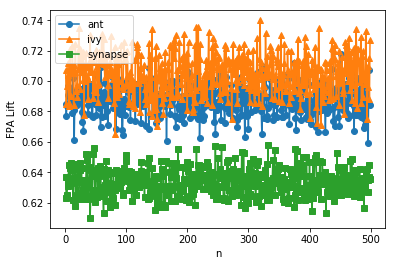

In [32]:
y.T.iloc[:,0].plot(style='-o')
y.T.iloc[:,1].plot(style='-^')
y.T.iloc[:,2].plot(style='-s')
plt.xlabel('n')
plt.ylabel('FPA Lift')
plt.legend(y.index)
# plt.savefig('n_test.svg')
plt.show()



## .svg文件
    SVG可以算是目前最最火热的图像文件格式了，它的英文全称为Scalable Vector Graphics，意思为可缩放的矢量图形。它是基于XML（Extensible Markup Language），由World Wide Web Consortium（W3C）联盟进行开发的。严格来说应该是一种开放标准的矢量图形语言，可让你设计激动人心的、高分辨率的Web图形页面。用户可以直接用代码来描绘图像，可以用任何文字处理工具打开SVG图像，通过改变部分代码来使图像具有交互功能，并可以随时插入到HTML中通过浏览器来观看。
